## Import Necessary Libraries

In [1]:
!pip install optuna
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import re
import optuna

## Importing the Data

In [2]:
df_train_and_val = pd.read_excel("train_and_val_set_economic_relationship.xlsx")[['content', 'Economic_Relationship']]

In [3]:
df_train_and_val

,content,Economic_Relationship
0,Çin'den Kazakistan'a Kuşak ve Yol Girişimi tek...,1
1,"Çin, ABD'ye gidecek vatandaşlarını uyardı \n ...",0
2,Cenevre Fuarı öncesi \n Oto...,0
3,“Dönüşmezsek ana pazarları Çin ve Hindistan'a ...,1
4,Çin nadir metallerin işlenmesine yönelik tekno...,0
...,...,...
398,"Cumhurbaşkanı Erdoğan, Çin Devlet Başkanı Şi i...",1
399,Güney Çin Denizi'nde gerilim: Baltalı ve bıçak...,0
400,Bakan Fidan’ın Çin ziyaretinin eko-politiği Tü...,1
401,Apple baskıya dayanamadı: WhatsApp ve Threads'...,0


In [4]:
df_train_and_val.groupby('Economic_Relationship').count()

,content
Economic_Relationship,
0,273
1,130


## BERT Model

In [5]:
# Split data into features and labels
texts = df_train_and_val['content'].tolist()
labels = df_train_and_val['Economic_Relationship'].tolist()

In [6]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-cased')

class NewspaperDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Define training and evaluation functions
def train_epoch(model, data_loader, optimizer, device, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        _, preds = torch.max(outputs.logits, dim=1)
        loss = outputs.loss

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    return correct_predictions.double() / n_examples, sum(losses) / n_examples

def eval_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            _, preds = torch.max(outputs.logits, dim=1)
            loss = outputs.loss

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions.double() / n_examples
    avg_loss = sum(losses) / n_examples
    class_report = classification_report(all_labels, all_predictions, output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # ✅ Now returns five values including predictions
    return accuracy, avg_loss, class_report, conf_matrix, all_predictions

In [8]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data split
train_idx, val_idx = train_test_split(
    list(range(len(texts))), test_size=0.3, stratify=labels, random_state=2
)
train_texts = [texts[i] for i in train_idx]
val_texts = [texts[i] for i in val_idx]
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

def objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float("lr", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 3, 8)
    seed = trial.suggest_int("seed", 1, 10000)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)

    # Set all seeds
    import random, os
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Prepare data
    train_dataset = NewspaperDataset(train_texts, train_labels, tokenizer)
    val_dataset = NewspaperDataset(val_texts, val_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = BertForSequenceClassification.from_pretrained(
        'dbmdz/bert-base-turkish-128k-cased', num_labels=2
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Train
    for epoch in range(num_epochs):
        train_epoch(model, train_loader, optimizer, device, len(train_dataset))

    # Evaluate
    _, _, _, _, val_preds = eval_model(model, val_loader, device, len(val_dataset))
    val_true = [val_labels[i] for i in range(len(val_preds))]

    # Per-class precision, recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(val_true, val_preds, average=None, labels=[0,1])
    f1_macro = f1.mean()
    f2_class_1 = (5 * precision[1] * recall[1]) / (4 * precision[1] + recall[1] + 1e-10)

    # Confusion Matrix
    conf = confusion_matrix(val_true, val_preds, labels=[0, 1])
    tn, fp, fn, tp = conf.ravel()

    # Optional: log metrics as trial attributes (can be accessed later)
    trial.set_user_attr("precision_0", precision[0])
    trial.set_user_attr("recall_0", recall[0])
    trial.set_user_attr("precision_1", precision[1])
    trial.set_user_attr("recall_1", recall[1])
    trial.set_user_attr("f1_macro", f1_macro)
    trial.set_user_attr("f2_class_1", f2_class_1)
    trial.set_user_attr("conf_matrix", conf.tolist())  # so it's serializable
    trial.set_user_attr("seed", seed)

    return f2_class_1  # 👈 changed from (f1_macro, f2_class_1) to only f2_class_1


# 🔁 SINGLE-objective study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

# Show top trial
best_trial = study.best_trial
print("\n✅ Best Trial (F2-class1):")
print(f"F2 (class 1): {best_trial.value:.4f}")
print(f"Precision (0): {best_trial.user_attrs['precision_0']:.4f}, Recall (0): {best_trial.user_attrs['recall_0']:.4f}")
print(f"Precision (1): {best_trial.user_attrs['precision_1']:.4f}, Recall (1): {best_trial.user_attrs['recall_1']:.4f}")
print(f"Seed: {best_trial.user_attrs['seed']}")
print("Confusion Matrix:")
print(np.array(best_trial.user_attrs["conf_matrix"]))

# Final model training with best params
best_params = best_trial.params

final_model = BertForSequenceClassification.from_pretrained(
    'dbmdz/bert-base-turkish-128k-cased', num_labels=2
).to(device)
final_optimizer = AdamW(final_model.parameters(), lr=best_params["lr"])

train_dataset = NewspaperDataset(train_texts, train_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

for epoch in range(best_params["num_epochs"]):
    train_epoch(final_model, train_loader, final_optimizer, device, len(train_dataset))

torch.save(final_model.state_dict(), 'bert_model_optimized_economicrelationship.pth')
print("\n✅ Final model saved as 'bert_model_optimized_economicrelationship.pth'")


[I 2025-05-18 18:24:13,564] A new study created in memory with name: no-name-76781531-afdd-411c-ada9-0e8330a6bb6e
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-18 18:24:57,065] Trial 0 finished with value: 0.8883248730758458 and parameters: {'lr': 1.4002065768423477e-05, 'batch_size': 64, 'num_epochs': 8, 'seed': 6004, 'weight_decay': 0.19636998126187685}. Best is trial 0 with value: 0.8883248730758458.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-


✅ Best Trial (F2-class1):
F2 (class 1): 0.9848
Precision (0): 1.0000, Recall (0): 0.9634
Precision (1): 0.9286, Recall (1): 1.0000
Seed: 9522
Confusion Matrix:
[[79  3]
 [ 0 39]]

✅ Final model saved as 'bert_model_optimized_economicrelationship.pth'


## Learning Curve

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

train_sizes = np.linspace(0.1, 0.9, 10)  # 10% to 100%
f2_scores = []

# Use same test/validation set throughout
train_idx, val_idx = train_test_split(list(range(len(texts))), test_size=0.3, stratify=labels, random_state=42)
val_texts = [texts[i] for i in val_idx]
val_labels = [labels[i] for i in val_idx]
val_dataset = NewspaperDataset(val_texts, val_labels, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=32)

for frac in tqdm(train_sizes):
    # Subsample training data
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=42)
    small_train_idx, _ = next(sss.split([texts[i] for i in train_idx], [labels[i] for i in train_idx]))

    sub_train_texts = [texts[train_idx[i]] for i in small_train_idx]
    sub_train_labels = [labels[train_idx[i]] for i in small_train_idx]

    # Prepare dataset and loader
    train_dataset = NewspaperDataset(sub_train_texts, sub_train_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Train simple model (fixed params for fair comparison)
    model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-128k-cased', num_labels=2).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    for epoch in range(4):  # fixed small number of epochs
        train_epoch(model, train_loader, optimizer, device, len(train_dataset))

    # Evaluate
    _, _, _, _, preds = eval_model(model, val_loader, device, len(val_dataset))
    true = val_labels
    precision, recall, _, _ = precision_recall_fscore_support(true, preds, average=None, labels=[0, 1])
    f2 = (5 * precision[1] * recall[1]) / (4 * precision[1] + recall[1] + 1e-10)
    f2_scores.append(f2)


  0%|          | 0/10 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 1/10 [00:04<00:44,  5.00s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 20%|██        | 2/10 [00:10<00:44,  5.59s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stre

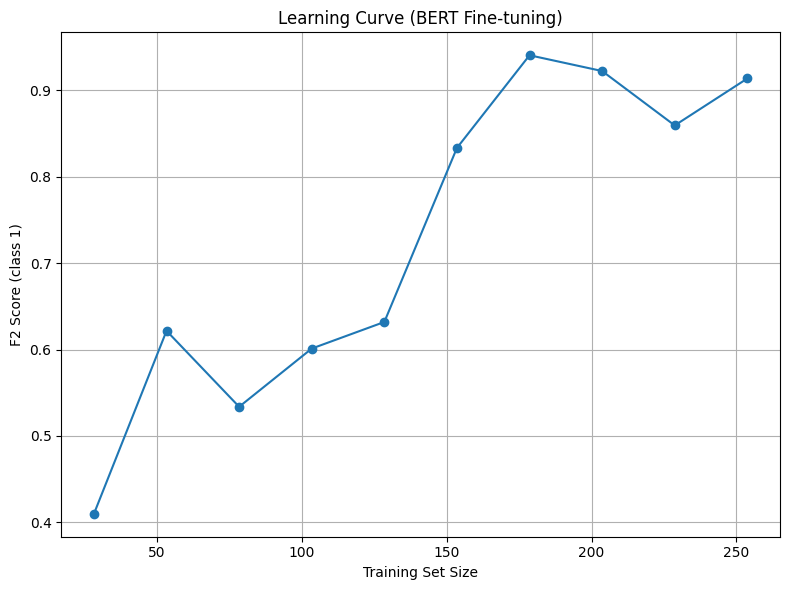

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes * len(train_idx), f2_scores, marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('F2 Score (class 1)')
plt.title('Learning Curve (BERT Fine-tuning)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Performance on the Test Set

In [11]:
df = pd.read_excel("test_set_economic_relationship.xlsx")[['content', 'Economic_Relationship']]

In [12]:
df

,content,Economic_Relationship
0,Aycı: Arda giderse Çin'e sponsor oluruz \n ...,1
1,Çin heyeti TBMM'de \n ANKARA - ...,1
2,Çin borsası 6 ayda yüzde 50 eridi \n ...,0
3,İran'dan AB'ye davet \n VİYANA ...,0
4,"Çin kamu şirketlerinde kâr erozyonu: Yüzde 2,1...",0
...,...,...
175,400 milyar dolarlık anlaşma \n ...,0
176,Kuzey Kore ile Çin'den yakın iş birliği sözü \...,0
177,"Çin gümrük vergisini indirdi, Türk markalar ha...",1
178,"Çin, munzam karşılıkları artırdı \n ...",0


In [13]:
# STEP 1: Extract test texts and labels
test_texts = df['content'].tolist()
test_labels = df['Economic_Relationship'].tolist()

# STEP 2: Create test dataset and loader
test_dataset = NewspaperDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

# STEP 3: Load the best model
best_model = BertForSequenceClassification.from_pretrained(
    'dbmdz/bert-base-turkish-128k-cased', num_labels=2
).to(device)
best_model.load_state_dict(torch.load('bert_model_optimized_economicrelationship.pth'))
best_model.eval()

# STEP 4: Evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Predict
_, _, _, _, test_preds = eval_model(best_model, test_loader, device, len(test_dataset))
test_true = [test_labels[i] for i in range(len(test_preds))]

# STEP 5: Compute metrics
acc = accuracy_score(test_true, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_true, test_preds, average=None, labels=[0, 1])
f2_class_1 = (5 * precision[1] * recall[1]) / (4 * precision[1] + recall[1] + 1e-10)
conf = confusion_matrix(test_true, test_preds, labels=[0, 1])

# STEP 6: Show results
print("\n📈 Test Set Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (class 0): {precision[0]:.4f}, Recall (class 0): {recall[0]:.4f}")
print(f"Precision (class 1): {precision[1]:.4f}, Recall (class 1): {recall[1]:.4f}")
print(f"F1 Scores: class 0 = {f1[0]:.4f}, class 1 = {f1[1]:.4f}")
print(f"F2 (class 1): {f2_class_1:.4f}")
print("Confusion Matrix:")
print(conf)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📈 Test Set Performance:
Accuracy: 0.9611
Precision (class 0): 0.9829, Recall (class 0): 0.9583
Precision (class 1): 0.9206, Recall (class 1): 0.9667
F1 Scores: class 0 = 0.9705, class 1 = 0.9431
F2 (class 1): 0.9571
Confusion Matrix:
[[115   5]
 [  2  58]]


## Saving the Model

In [14]:
from google.colab import drive
import os
import shutil

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the target folder in Google Drive
target_folder = '/content/drive/MyDrive/bert_predictions'
os.makedirs(target_folder, exist_ok=True)  # create it if it doesn't exist

# 3. Define the list of files you want to copy from Colab to Drive
files_to_save = [
    'bert_model_optimized_economicrelationship.pth',
]

# 4. Copy files to the Google Drive folder
for file in files_to_save:
    if os.path.exists(file):
        shutil.copy(file, target_folder)
        print(f"✅ Copied: {file}")
    else:
        print(f"❌ File not found: {file}")

Mounted at /content/drive
✅ Copied: bert_model_optimized_economicrelationship.pth
